In [1]:
import astropy.io.fits as pf
import pylab as mplot
%pylab inline
import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord
from pylab import cm
mplot.rc('text', usetex=True)
mplot.rc('font', family='serif')
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)


Populating the interactive namespace from numpy and matplotlib


In [2]:
planck = pf.open('HFI_PCCS_SZ-union_R2.08.fits')
planck_data = pf.open('HFI_PCCS_SZ-union_R2.08.fits')[1].data

In [3]:
z = planck_data['redshift']
snr = planck_data['snr']
mass = planck_data['MSZ']
ra = planck_data['ra']
dec = planck_data['dec']
lon = planck_data['glon']
lat = planck_data['glat']

In [4]:
# find the 40 highest SNR clusters with 0<z<0.2
N = 10
id_snr = np.argsort(snr[(z>0)*(z<0.2)])[-1*N:][::-1]
mass_sel = mass[(z>0)*(z<0.2)][id_snr]
snr_sel = snr[(z>0)*(z<0.2)][id_snr]

RA_sel, DEC_sel = ra[(z>0)*(z<0.2)][id_snr], dec[(z>0)*(z<0.2)][id_snr]
LON_sel, LAT_sel = lon[(z>0)*(z<0.2)][id_snr], lat[(z>0)*(z<0.2)][id_snr]

Z_sel = z[(z>0)*(z<0.2)][id_snr]
SNR_sel = snr[(z>0)*(z<0.2)][id_snr]
MASS_sel = mass[(z>0)*(z<0.2)][id_snr]
print(RA_sel, DEC_sel)

[290.28985941 256.10046544  67.80918357 137.23403477 194.91179667
 249.5788636  239.60047098 303.08392178 258.18452453 227.72895004] [ 43.97486408  78.63246891 -61.4069601   -9.67249374  27.95367899
 -64.35937536  27.21225339 -56.814789    64.05898905   5.76810149]


In [5]:
sz_map = hp.read_map('COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits', nest=False)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:326: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


In [6]:
nside = 2048
pix = np.arange(hp.nside2npix(nside))
theta_y, phi_y = hp.pix2ang(nside, pix)
lon_y = phi_y/np.pi*180
lat_y = 90.-(theta_y/np.pi*180)

In [7]:
# c1 = SkyCoord(LON_sel*u.degree, LAT_sel*u.degree, frame='icrs')
# c2 = SkyCoord(lon_y*u.degree, lat_y*u.degree, frame='icrs')
# sep = c1.separation(c2)
# mask_cluster = (sep.degree<5)

# mplot.figure(figsize=(8.5,7))
# mplot.scatter(lat_y[mask_cluster], (90. - lon_y[mask_cluster]), c=sz_map[mask_cluster], cmap='nipy_spectral')
# mplot.colorbar()

0


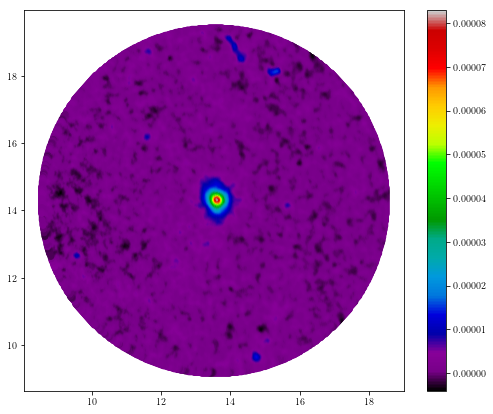

95748
1


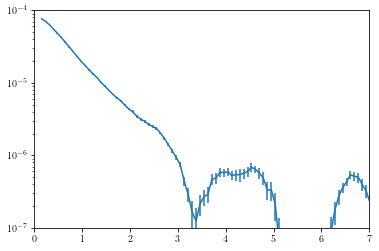

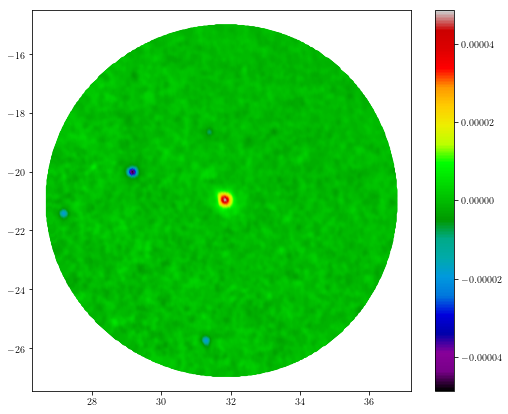

95772
2


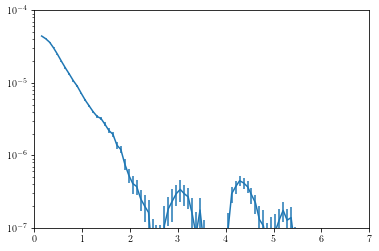

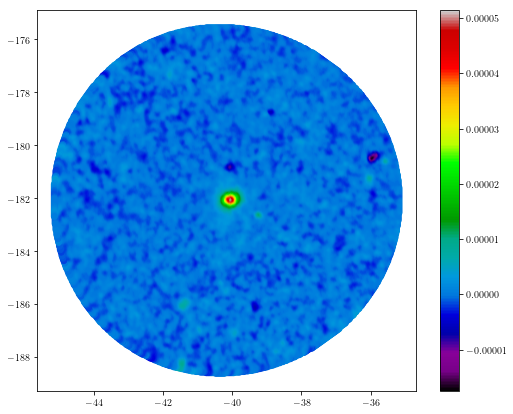

95751
3


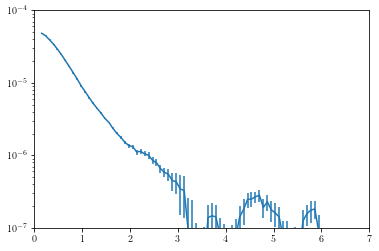

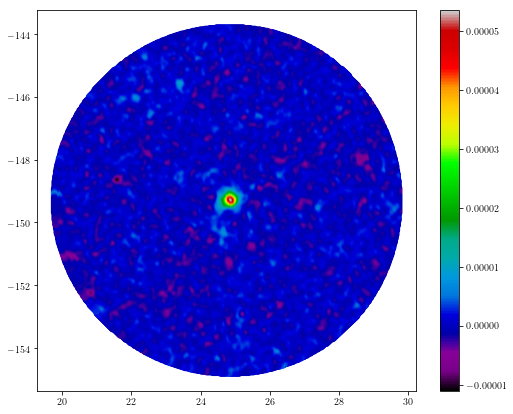

95773
4


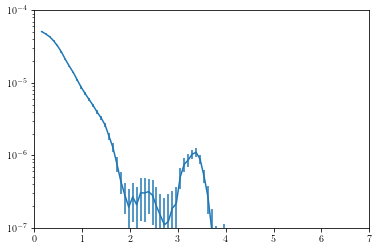

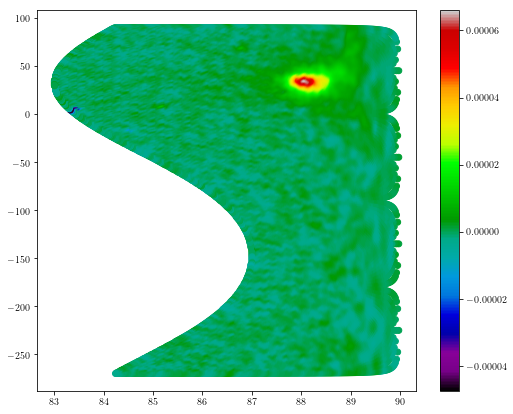

95757
5


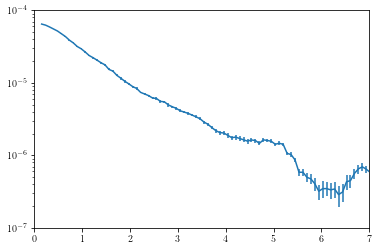

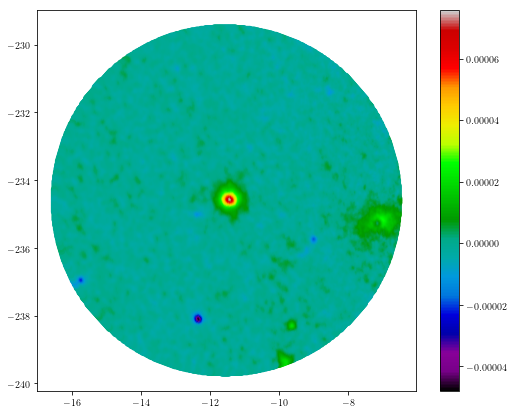

95759
6


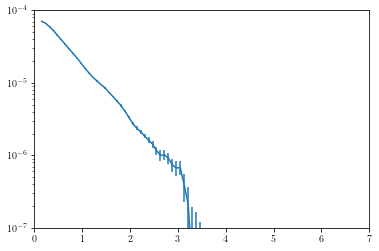

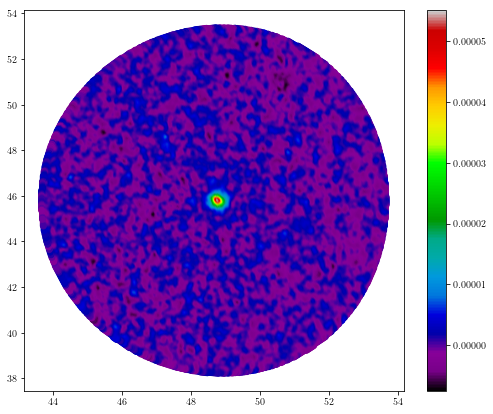

95761
7


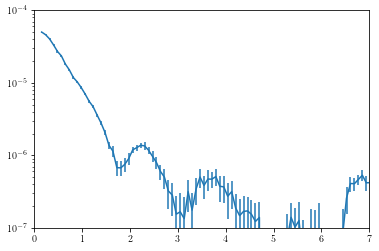

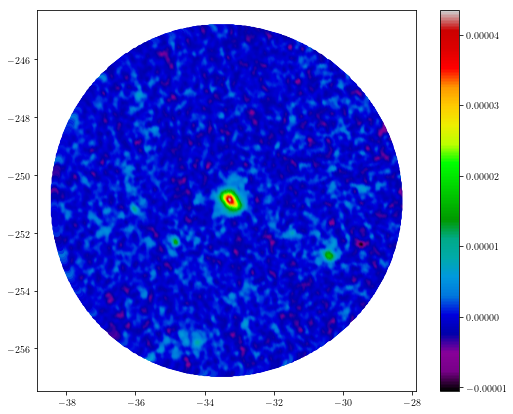

95775
8


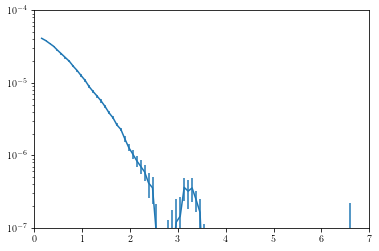

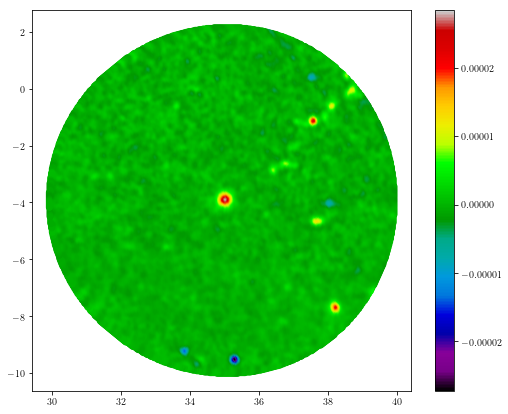

95756
9


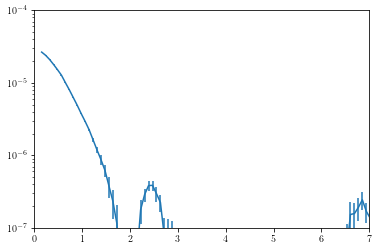

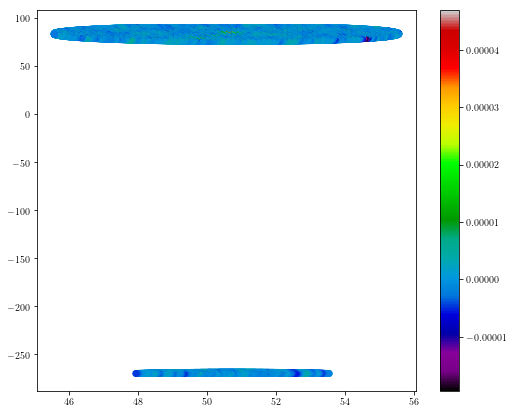

95749


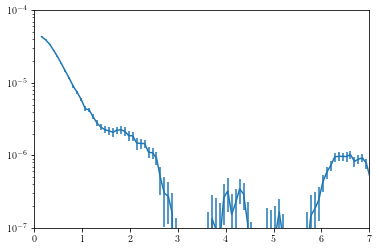

In [8]:
for k in range(10):
    print(k)

    c1 = SkyCoord(LON_sel[k]*u.degree, LAT_sel[k]*u.degree, frame='icrs')
    c2 = SkyCoord(lon_y*u.degree, lat_y*u.degree, frame='icrs')
    sep = c1.separation(c2)
    mask_cluster = (sep.degree<5)

    mplot.figure(figsize=(8.5,7))
    mplot.scatter(lat_y[mask_cluster], (90. - lon_y[mask_cluster]), c=sz_map[mask_cluster], cmap='nipy_spectral')
    mplot.colorbar()
    mplot.show()


    ids = np.arange(len(sz_map[mask_cluster]))
    print(len(sz_map[mask_cluster]))
    Npix = len(sz_map[mask_cluster])
    bg_mask = (sep.value[mask_cluster]>3)

    bin_edge = np.linspace(2, 300.0, num=201)
    bin_min = bin_edge[:-1]
    bin_max = bin_edge[1:]

    Y_boot = []
    Y_boot_err = []

    for i in range(100):
        ids_new = np.random.choice(ids, size=Npix, replace=True)

        c2_new = SkyCoord(lon_y[mask_cluster][ids_new]*u.degree, lat_y[mask_cluster][ids_new]*u.degree, frame='icrs')
        sep_new = c1.separation(c2_new)

        bg_mask_new = bg_mask[ids_new]
        bg = np.median(sz_map[mask_cluster][bg_mask_new])

        Y = []
    #     Yerr = []
        for j in range(200):
            mask = (np.array(sep_new.degree) >= bin_min[j]/60)*(np.array(sep_new.degree) < bin_max[j]/60)
            Y.append(np.mean(sz_map[mask_cluster][ids_new][mask]))
    #         Yerr.append(np.std(sz_map[mask_cluster][ids_new][mask])/np.sqrt(len(sz_map[mask_cluster][ids_new][mask])))
    #         Yerr.append(np.std(sz_map[mask_cluster][ids_new][mask]))

        Y = np.array(Y)
        Y_boot.append(Y)
    #     Yerr = np.array(Yerr)
    #     Y_boot_err.append(Yerr)

    #     mplot.plot(Y)

    Y_boot = np.array(Y_boot)
    # Y_boot_err = np.array(Y_boot_err)

    Y_err = np.std(Y_boot, axis=0)
    Y_mean = np.mean(Y_boot, axis=0)

    DD = (bin_min+bin_max)/2/18
    # D = cosmo.comoving_distance(Z_sel).value/(1+Z_sel)
    # DD = D*(bin_min+bin_max)/2/60/180*np.pi

    mplot.errorbar(DD, Y_mean-bg, yerr=Y_err)
    #mplot.xscale('log')
    mplot.yscale('log')
    mplot.xlim(0,7)
    mplot.ylim(1e-7,1e-4)
    
    cov_boot = np.cov(Y_boot.T)

    np.savez('Planck_cluster_bootstrap_'+str(k)+'.npz', ra=RA_sel[k], dec=DEC_sel[k], lon=LON_sel[k], 
             lat=LAT_sel[k], z=Z_sel[k], mass=MASS_sel[k], snr=SNR_sel[k], theta=(bin_min+bin_max)/2, 
             R_over_R500=DD, mean_y=Y_mean, bg=bg, cov=cov_boot)
    
    
    

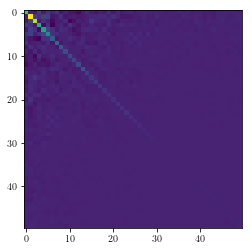

In [74]:
cov_boot = np.cov(Y_boot.T)
mplot.imshow(cov_boot[:50,:50])

In [75]:
cov_norm = cov_boot[:50,:50].copy()
for i in range(50):
    for j in range(50):
        cov_norm[i][j] /= np.sqrt(cov_boot[:50,:50][i][i]*cov_boot[:50,:50][j][j])

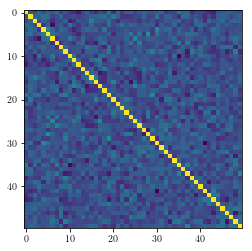

In [76]:
mplot.imshow(cov_norm)

In [77]:
np.savez('Hurier_cluster_bootstrap.npz', theta=(bin_min+bin_max)/2, R_over_R500=DD, mean_y=Y_mean, bg=bg, cov=cov_boot)

In [ ]:
# calculate R500
# calculate beam size
# does planck have sims for y-map?